[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/test2.ipynb)


# __Classifying Dark Matter Substructure using Convolutional Visual Transformer (CvT) with E(2)-steerable kernels__

This approach combines Haiping Wu et al., <b> Convolutional vision Transformer (CvT) </b>, and Maurice Weiler et al., <b> General E(2) - Equivariant Steerable CNN </b> with an aim to make the network rotation equivariant. It leverages the properties of CvT - shift, scale, and distortion invariance, dynamic attention, global context - and Equivariant Steerable CNNs - equivariant under all isometries E(2) of the image plane. So, in this way, an inductive bias for rotation could be added to the network as we already know about the existing symmetries in the dataset. 

This is accomplished through a modification: Equivariant Steerable convolutional kernels (C4) are added before the CvT architecture. The CvT used in this solution is a lightweight version of the one employed in test2.ipynb as it only uses single stage of CvT.

This resulted in a high-accuracy and lightweight Vision transformer with only 65k trainable parameters. It was tested on RTX 2070 8 GB (Laptop version) with the given [dataset](https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing). The experiment with such a modification opens up the door toward building equivariant vision transformers. 

## __Results__

| S.No | Metric | Value |
| --- | --- | --- |
| 1. | Best validation accuracy | 90.06% |
| 2. | AUC (with sub structure)  | 0.9783 |
| 3. | AUC (without sub structure)  | 0.9822 |

# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies. The cell also clone the solution repo as it contains a custom file for Convolutional Vision Transformers (CvT). 

In [1]:
# !pip install  split-folders \
#               torchinfo \
#               einops \
#               e2cnn
# !pip install --upgrade --no-cache-dir gdown

In [2]:
# run in the case of Colab only
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [ ]:
# %%bash
# bash setup.bash

# __Essential imports__

In [1]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from torchinfo import summary
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix



## __Make required folders for data and models__

In [2]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
A set of simulated strong gravitational lensing images with and without substructure. 

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With substructure | 5000 |
| 2. | Without substructure | 5000 |

In [3]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
    lenses
    ├── train
    │   ├── no_sub
    │   └── sub
    └── val
        ├── no_sub
        └── sub
```

In [4]:
# initialize the data directory name  
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracted folder exists


In [5]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [6]:
# Data setting
n_classes = 2               # number of classes to be classified
image_size = 129            # image size (224x224)

# Training parameters
batch_size = 8              # batch size
epochs = 40                 # number of epochs
lr = 1e-4                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning rate 
step_size_opt = 5           # interval to apply optimizer scheduler
use_lr_schedule = False     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # use CUDA or not
cuda_idx = 0                # idx of CUDA device to be used

In [7]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## __Select CUDA device for training__

In [8]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [9]:
device = get_device(use_cuda, cuda_idx)


Using device = cuda:0


## __Logger to save the results__

In [10]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [11]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## __Set the path for saving trained model__

In [12]:
PATH = os.path.join("model", f"e2cnn_vit_{current_time}.pt")

## __Transformations__ 

Following transformations are performed on the dataset:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
7. Resized to $129 \times 129$.
8. Converting to grayscale
9. Converting PIL image to tensor

Transformation are same as test1.ipynb as it uses the E(2)-Steerable convolutional kernels in the first layer.

In [13]:
# images are padded to have shape 129x129.
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts
# upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [14]:
def get_transform_train():

    random_transform = []

    transform1 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        ])
  
    transform2 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        ])

    transform_list = [transform1, transform2]

    transform_prob = 1.0 / len(transform_list)
    for transform in transform_list:
        random_transform.append( transforms.RandomApply([transform], transform_prob) )


    transform_train = Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        # transforms.RandomApply(random_transform, 0.9999),
        Resize((224, 224)),
        togray,
        totensor,
    ])

    transform_train_eq = transforms.Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(180, resample=Image.BILINEAR, expand=False),
        resize2,
        togray,
        totensor,
    ])
    
    return transform_train_eq

transform_test = Compose([
    transforms.RandomCrop(128),
    pad,
    resize2,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [15]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [16]:
trainset = CustomDataset(data_dir,'train',transform=get_transform_train())
valset = CustomDataset(data_dir,'val',transform=transform_test)

## __Dataloader__ 
Loading train and test data with shuffle and given batch size

In [17]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## __Visualize train image samples__

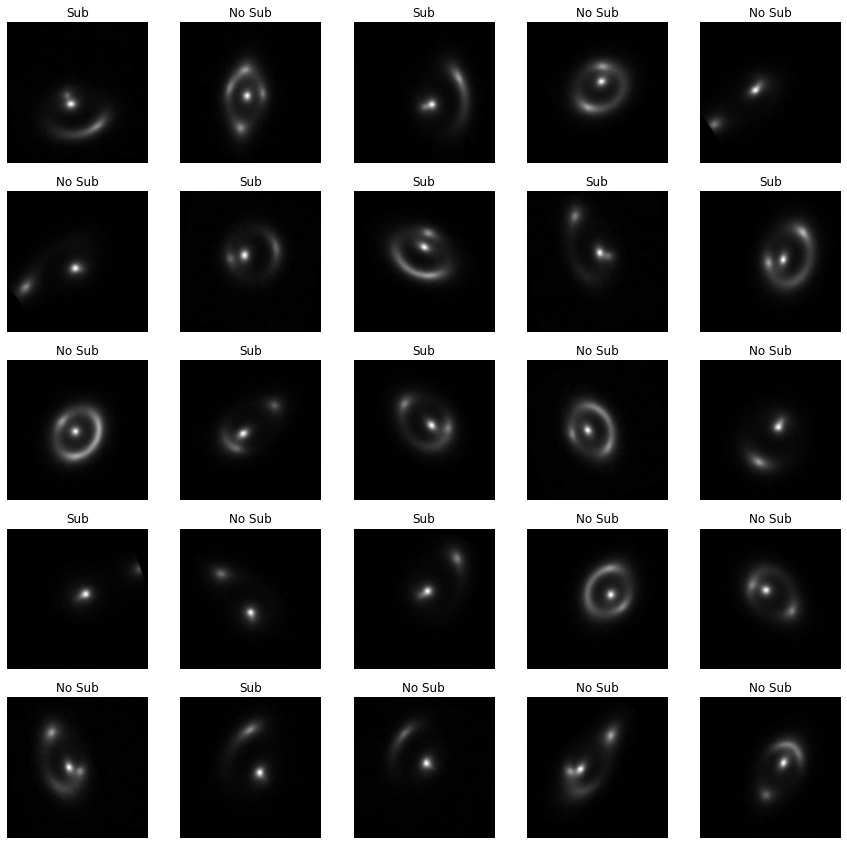

In [18]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im, cmap='gray')
plt.show()

In [19]:
# get the number of samples in train and test set
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


### **Model Definition**
Since the input images are gray-scale, the input model type will be scalar field. Inside the network, we use regular fields. Group pooling is used to build invariant features just before the CvT layers.Single stage CvT is used for learning further resprentation and classification. 

In [20]:
# Lightweight CvT model
from cvt import CvT, EqCvT
v = EqCvT(
    channels = 1,
    num_classes = 2,
    s1_emb_dim = 32,       # stage 1 - (same as above)
    s1_emb_kernel = 3,
    s1_emb_stride = 2,
    s1_proj_kernel = 3,
    s1_kv_proj_stride = 2,
    s1_heads = 3,
    s1_depth = 2,
    s1_mlp_mult = 2,
    mlp_last = 64,
    dropout = 0.1,
    sym_group = 'Circular', 
    N = 4,
    image_size=image_size,
    e2cc_mult_1 = 10,
).to(device)

# print(v)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(v))
print(v)
# summary(v, input_size=(batch_size, 1, 224, 224))

/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  full_mask[mask] = norms.to(torch.uint8)


64810
EqCvT(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([4-Rotations: {irrep_0}], [4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}])
  )
  (pool1): PointwiseAvgPoolAntialiased()
  (gpool): GroupPooling([4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}])
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm()
      (2): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
 

### Training

In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)

In [22]:
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []
all_test_accuracy = []
all_epoch_loss = []

best_accuracy = 0

for epoch in range(epochs):
    v.train()
    epoch_loss = 0
    epoch_accuracy = 0
    tr_loss_epoch = []
    running_loss = 0


    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = v(data)
        loss = criterion(output, label)
        epoch_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = epoch_loss / len(train_loader)
    all_epoch_loss.append(epoch_loss)

    correct = 0

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = criterion(val_output, label)
 
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss 
            
        epoch_val_accuracy =epoch_val_accuracy / len(valid_loader)
        epoch_val_loss =epoch_val_loss / len(valid_loader)
        all_val_loss.append(epoch_val_loss)

    
    all_val_accuracy.append(epoch_val_accuracy.item()*100)
    logging.debug(        
        f"Epoch : {epoch+1} - LR {optimizer.param_groups[0]['lr']:.8f} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
    )

    if use_lr_schedule:
        # scheduler_plateau.step(epoch_val_loss)
        scheduler_step.step() 

    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(v)  
        torch.save(best_model.state_dict(), PATH)

DEBUG:root:Epoch : 1 - LR 0.00010000 - loss : 0.5970 - val_loss : 0.5368 - val_acc: 0.7360 



DEBUG:root:Epoch : 2 - LR 0.00010000 - loss : 0.4638 - val_loss : 0.4246 - val_acc: 0.7950 



DEBUG:root:Epoch : 3 - LR 0.00010000 - loss : 0.3863 - val_loss : 0.3418 - val_acc: 0.8360 



DEBUG:root:Epoch : 4 - LR 0.00010000 - loss : 0.3341 - val_loss : 0.3872 - val_acc: 0.8240 



DEBUG:root:Epoch : 5 - LR 0.00010000 - loss : 0.3152 - val_loss : 0.3030 - val_acc: 0.8650 



DEBUG:root:Epoch : 6 - LR 0.00010000 - loss : 0.2838 - val_loss : 0.2610 - val_acc: 0.8860 



DEBUG:root:Epoch : 7 - LR 0.00010000 - loss : 0.2662 - val_loss : 0.2456 - val_acc: 0.8950 



DEBUG:root:Epoch : 8 - LR 0.00010000 - loss : 0.2653 - val_loss : 0.2581 - val_acc: 0.8870 



DEBUG:root:Epoch : 9 - LR 0.00010000 - loss : 0.2485 - val_loss : 0.2646 - val_acc: 0.8780 



DEBUG:root:Epoch : 10 - LR 0.00010000 - loss : 0.2434 - val_loss : 0.2340 - val_acc: 0.8980 



DEBUG:root:Epoch : 11 - LR 0.00010000 - loss : 0.2270 - val_loss : 0.2242 - val_acc: 0.9060 



DEBUG:root:Epoch : 12 - LR 0.00010000 - loss : 0.2203 - val_loss : 0.2310 - val_acc: 0.8880 



DEBUG:root:Epoch : 13 - LR 0.00010000 - loss : 0.2097 - val_loss : 0.2821 - val_acc: 0.8680 



DEBUG:root:Epoch : 14 - LR 0.00010000 - loss : 0.2052 - val_loss : 0.1808 - val_acc: 0.9220 



DEBUG:root:Epoch : 15 - LR 0.00010000 - loss : 0.1961 - val_loss : 0.2057 - val_acc: 0.9070 



DEBUG:root:Epoch : 16 - LR 0.00010000 - loss : 0.1913 - val_loss : 0.1869 - val_acc: 0.9210 



DEBUG:root:Epoch : 17 - LR 0.00010000 - loss : 0.1846 - val_loss : 0.1831 - val_acc: 0.9180 



DEBUG:root:Epoch : 18 - LR 0.00010000 - loss : 0.1937 - val_loss : 0.2392 - val_acc: 0.8910 



DEBUG:root:Epoch : 19 - LR 0.00010000 - loss : 0.1807 - val_loss : 0.1773 - val_acc: 0.9280 



DEBUG:root:Epoch : 20 - LR 0.00010000 - loss : 0.1714 - val_loss : 0.1929 - val_acc: 0.9270 



DEBUG:root:Epoch : 21 - LR 0.00010000 - loss : 0.1737 - val_loss : 0.1794 - val_acc: 0.9240 



DEBUG:root:Epoch : 22 - LR 0.00010000 - loss : 0.1722 - val_loss : 0.1724 - val_acc: 0.9280 



DEBUG:root:Epoch : 23 - LR 0.00010000 - loss : 0.1703 - val_loss : 0.2259 - val_acc: 0.9000 



DEBUG:root:Epoch : 24 - LR 0.00010000 - loss : 0.1677 - val_loss : 0.1588 - val_acc: 0.9290 



DEBUG:root:Epoch : 25 - LR 0.00010000 - loss : 0.1617 - val_loss : 0.1707 - val_acc: 0.9300 



DEBUG:root:Epoch : 26 - LR 0.00010000 - loss : 0.1684 - val_loss : 0.1797 - val_acc: 0.9280 



DEBUG:root:Epoch : 27 - LR 0.00010000 - loss : 0.1435 - val_loss : 0.1879 - val_acc: 0.9260 



DEBUG:root:Epoch : 28 - LR 0.00010000 - loss : 0.1487 - val_loss : 0.1417 - val_acc: 0.9450 



DEBUG:root:Epoch : 29 - LR 0.00010000 - loss : 0.1401 - val_loss : 0.1564 - val_acc: 0.9320 



DEBUG:root:Epoch : 30 - LR 0.00010000 - loss : 0.1436 - val_loss : 0.1353 - val_acc: 0.9530 



DEBUG:root:Epoch : 31 - LR 0.00010000 - loss : 0.1508 - val_loss : 0.1183 - val_acc: 0.9590 



DEBUG:root:Epoch : 32 - LR 0.00010000 - loss : 0.1391 - val_loss : 0.1326 - val_acc: 0.9430 



DEBUG:root:Epoch : 33 - LR 0.00010000 - loss : 0.1538 - val_loss : 0.1607 - val_acc: 0.9380 



DEBUG:root:Epoch : 34 - LR 0.00010000 - loss : 0.1323 - val_loss : 0.1739 - val_acc: 0.9320 



DEBUG:root:Epoch : 35 - LR 0.00010000 - loss : 0.1365 - val_loss : 0.1390 - val_acc: 0.9410 



DEBUG:root:Epoch : 36 - LR 0.00010000 - loss : 0.1366 - val_loss : 0.1651 - val_acc: 0.9300 



DEBUG:root:Epoch : 37 - LR 0.00010000 - loss : 0.1440 - val_loss : 0.1373 - val_acc: 0.9430 



DEBUG:root:Epoch : 38 - LR 0.00010000 - loss : 0.1257 - val_loss : 0.1162 - val_acc: 0.9520 



DEBUG:root:Epoch : 39 - LR 0.00010000 - loss : 0.1380 - val_loss : 0.1967 - val_acc: 0.9230 



DEBUG:root:Epoch : 40 - LR 0.00010000 - loss : 0.1349 - val_loss : 0.1214 - val_acc: 0.9510 



In [23]:
!nvidia-smi

Mon Apr  4 23:20:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8    16W /  N/A |   5564MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

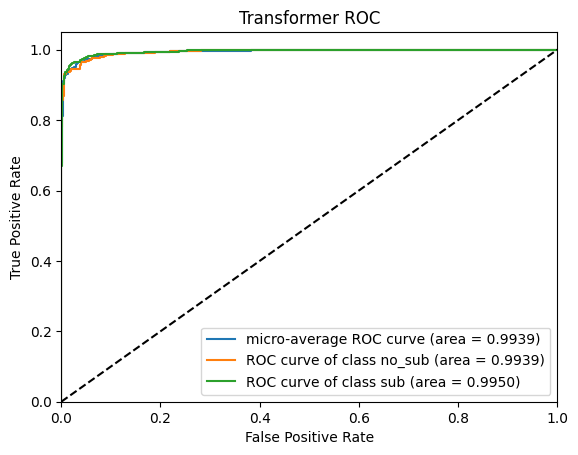

In [24]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(n_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0f73f57b20>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0f73f57b20>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


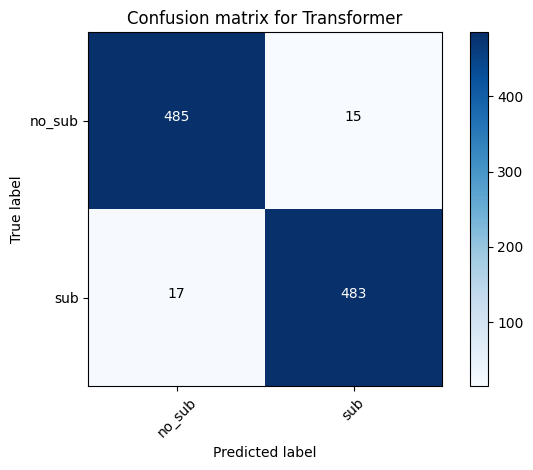

In [26]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1]],title='Confusion matrix for Transformer')